## Random forest for SRQ prediction with more feature engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import warnings
import joblib
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('pipeline/FlightsByDay-SRQ-2025_07_21_09_49_46.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13279 entries, 0 to 13278
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 13279 non-null  datetime64[ns]
 1   Flight               13279 non-null  object        
 2   Destination Airport  13279 non-null  object        
 3   Airline              13279 non-null  object        
 4   Boarded              13279 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 518.8+ KB


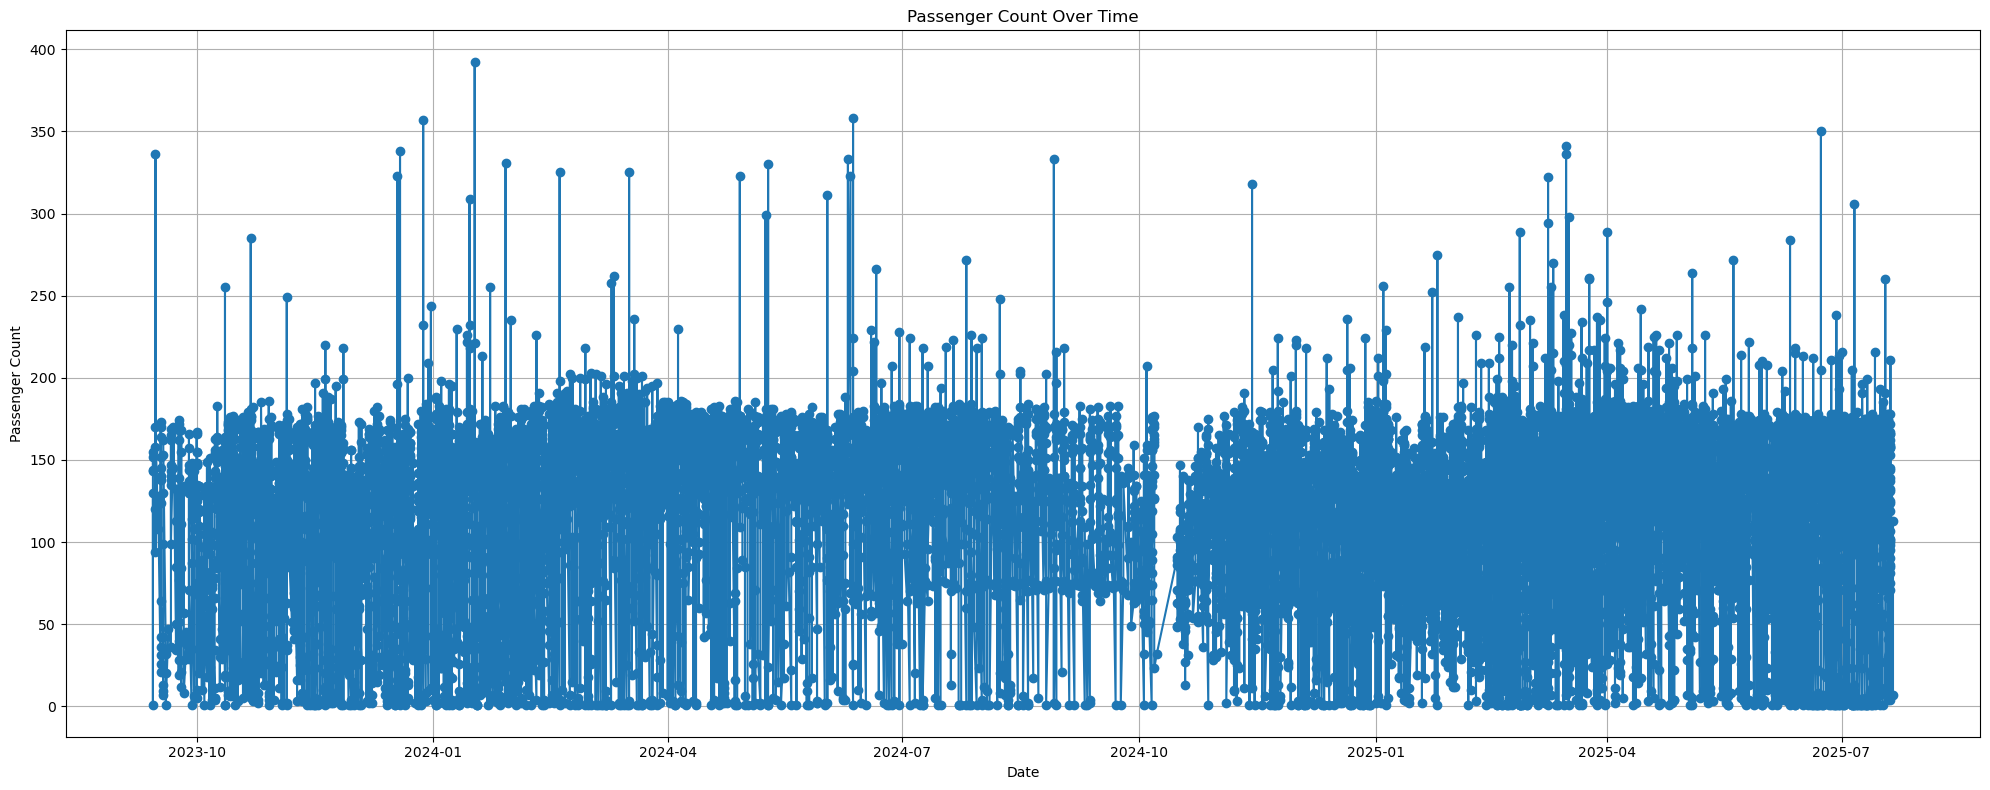

In [3]:
plt.figure(figsize=(20,8))
plt.plot(df['Date'], df['Boarded'], marker='o', linestyle='-')
plt.title('Passenger Count Over Time')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# Extract time-based features
#df['Hour'] = df['Flight Time'].dt.hour
df['Day_of_Week'] = df['Date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Month'] = df['Date'].dt.month
df['Day_of_Month'] = df['Date'].dt.day

# Create time-based categories
#df['Time_Category'] = pd.cut(df['Hour'], 
                           #bins=[0, 6, 12, 18, 24], 
                           #labels=['Night', 'Morning', 'Afternoon', 'Evening'])

# Encode categorical variables
label_encoders = {}
categorical_columns = ['Destination Airport', 'Airline']

for col in categorical_columns:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


df

,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded
0,2023-09-14,AA2679,DFW,AA,130,3,9,14,25,0
1,2023-09-14,AA5521,CLT,AA,1,3,9,14,19,0
2,2023-09-14,G41150,PIT,G4,155,3,9,14,72,5
3,2023-09-14,G4183,ABE,G4,152,3,9,14,1,5
4,2023-09-14,G4218,AVL,G4,144,3,9,14,8,5
...,...,...,...,...,...,...,...,...,...,...
13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,55,9
13275,2025-07-20,WN4606,STL,WN,75,6,7,20,88,9
13276,2025-07-20,XP306,HVN,XP,132,6,7,20,40,10
13277,2025-07-21,G41355,CAK,G4,7,0,7,21,16,5


## Cyclical encoding of dates

In [9]:
df['day_sin'] = np.sin(2*np.pi*df['Day_of_Month']/31)
df['day_cos'] = np.cos(2*np.pi*df['Day_of_Month']/31)

# Month (1–12) → convert to 0–11 by subtracting 1, then encode
df['month_sin'] = np.sin(2 * np.pi * (df['Month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['Month'] - 1) / 12)

# Day of Week → if 0=Monday…6=Sunday, just divide by 7
df['dow_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13279 entries, 0 to 13278
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13279 non-null  datetime64[ns]
 1   Flight                       13279 non-null  object        
 2   Destination Airport          13279 non-null  object        
 3   Airline                      13279 non-null  object        
 4   Boarded                      13279 non-null  int64         
 5   Day_of_Week                  13279 non-null  int32         
 6   Month                        13279 non-null  int32         
 7   Day_of_Month                 13279 non-null  int32         
 8   Destination Airport_encoded  13279 non-null  int32         
 9   Airline_encoded              13279 non-null  int32         
 10  day_sin                      13279 non-null  float64       
 11  day_cos                      13279 non-nu

## group by airline and destination

In [13]:
route_stats = df.groupby(['Airline','Destination Airport'])['Boarded'].agg([
    ('route_mean','mean'),
    ('route_median','median'),
    ('route_std','std'),
]).reset_index()
df = df.merge(route_stats, on=['Airline','Destination Airport'], how='left')
df

,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,2023-09-14,AA2679,DFW,AA,130,3,9,14,25,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,81.282051,73.0,61.456442
1,2023-09-14,AA5521,CLT,AA,1,3,9,14,19,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,71.391808,73.0,46.339267
2,2023-09-14,G41150,PIT,G4,155,3,9,14,72,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,147.602694,162.0,38.527768
3,2023-09-14,G4183,ABE,G4,152,3,9,14,1,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,147.664894,157.0,35.426650
4,2023-09-14,G4218,AVL,G4,144,3,9,14,8,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,124.893333,132.0,36.502656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13274,2025-07-20,WN4605,MDW,WN,125,6,7,20,55,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,117.842391,122.0,42.476508
13275,2025-07-20,WN4606,STL,WN,75,6,7,20,88,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,115.578947,127.0,40.685602
13276,2025-07-20,XP306,HVN,XP,132,6,7,20,40,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.097113,128.0,40.302129
13277,2025-07-21,G41355,CAK,G4,7,0,7,21,16,5,-0.897805,-0.440394,1.224647e-16,-1.0,0.000000,1.000000,152.206107,160.0,24.475093


In [14]:
# Select features for modeling
feature_columns = [
    'Destination Airport_encoded', 
    'Airline_encoded', 'Day_of_Week', 'Month', 
    'Day_of_Month', 'day_sin', 'day_cos', 'month_sin',
    'month_cos', 'dow_sin', 'dow_cos', 'route_mean',
    'route_median', 'route_std'
]

X = df[feature_columns]
y = df['Boarded']

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)

Feature matrix shape: (13279, 14)
Target shape: (13279,)


In [15]:
#Need to drop time stamps for modeling but need the timestamps to present data
df_timestamps = df['Date']

split_factor = 0.8
split_index = int(len(df) * split_factor)

train_df = df[:split_index]
test_df = df[split_index:]

# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=None
# )

# Extract X and y from train and test sets
X_train = train_df[feature_columns]
y_train = train_df['Boarded']

X_test = test_df[feature_columns]
y_test = test_df['Boarded']


print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"Training target range: {y_train.min()} to {y_train.max()}")
print(f"Testing target range: {y_test.min()} to {y_test.max()}")

Training set size: 10623
Testing set size: 2656
Training target range: 1 to 392
Testing target range: 1 to 350


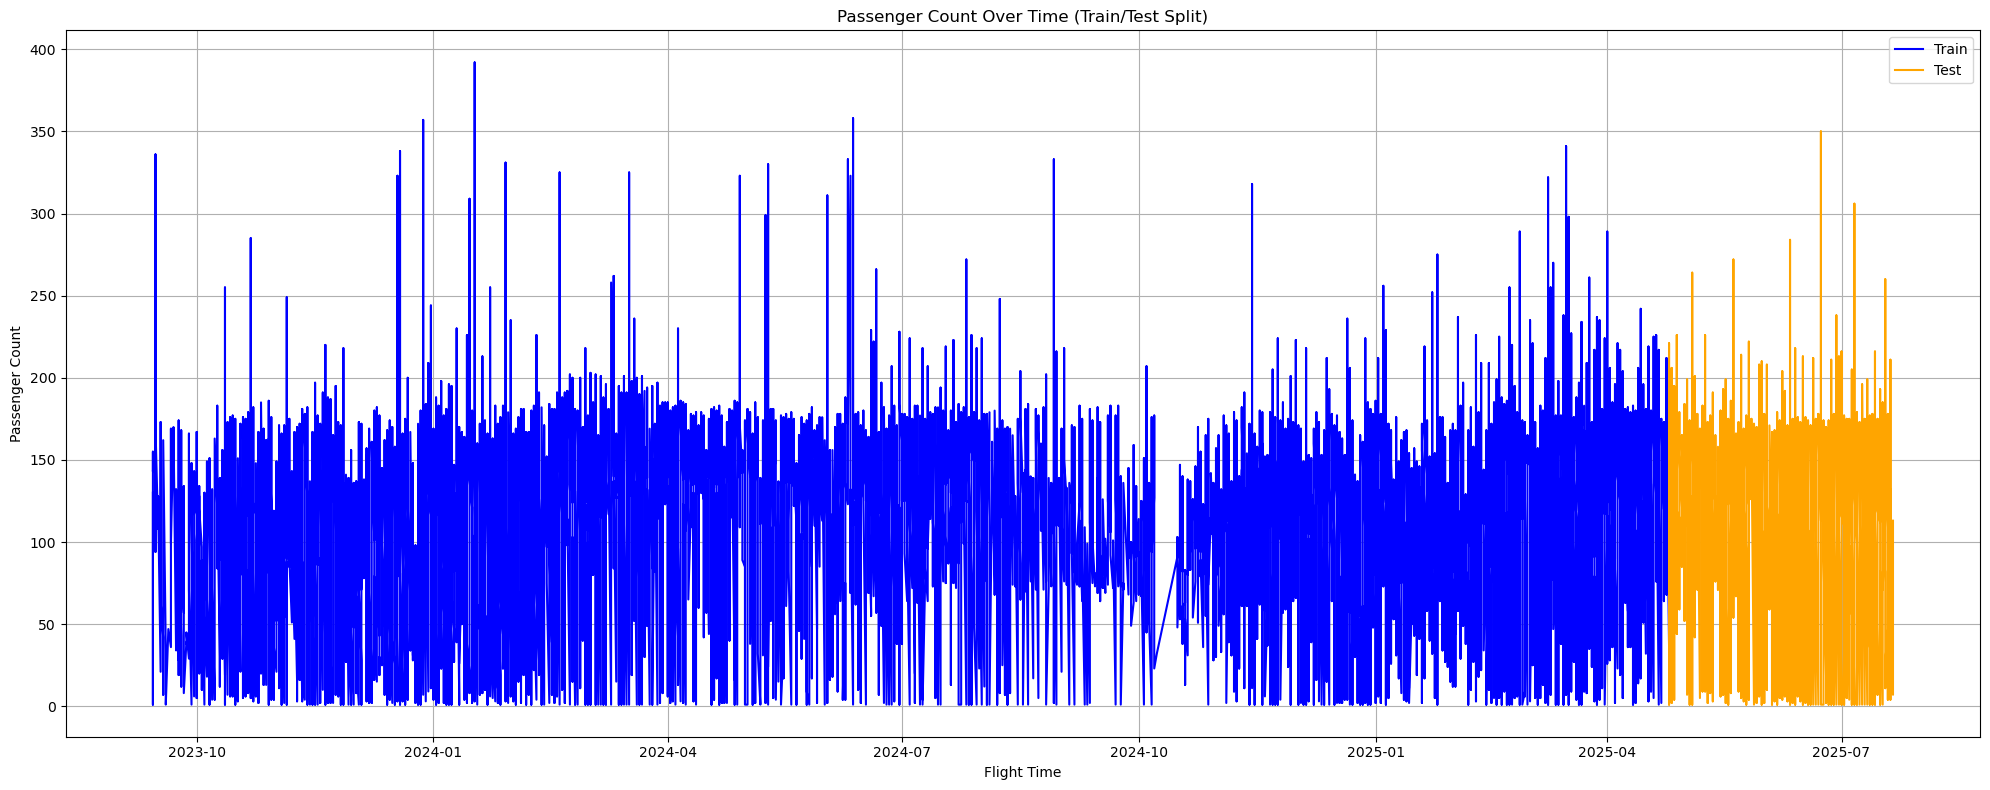

In [16]:
plt.figure(figsize=(20,8))

plt.plot(df_timestamps[:split_index], y_train, label='Train', color='blue')
plt.plot(df_timestamps[split_index:], y_test, label='Test', color='orange')

plt.title('Passenger Count Over Time (Train/Test Split)')
plt.xlabel('Flight Time')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
param_grid_random = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

In [18]:
rf = RandomForestRegressor()
tscv= TimeSeriesSplit(3)

In [19]:
print("Starting Randomized Search...")
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_random,
    n_iter=100,  # Number of parameter combinations to try
    cv=tscv,
    scoring='neg_mean_squared_error',  # Use 'neg_mean_squared_error' for regression
    n_jobs=-1,
    verbose=1,
    random_state=42
)

Starting Randomized Search...


In [20]:
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4, 6],
                                        'min_samples_split': [2, 5, 10, 15],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [21]:
# Get the best model
best_rf = random_search.best_estimator_
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Make predictions
y_pred = best_rf.predict(X_test)

Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}
Best cross-validation score: -1651.5809


In [29]:
def predict_passengers(model, flight_time, dest_airport, airline,
                       label_encoders, route_stats, feature_columns):
    # 1) Build base DataFrame
    sample = pd.DataFrame({'Flight Time': [flight_time]})
    
    # 2) Extract raw time features
    dt = pd.to_datetime(sample['Flight Time'])
    sample['Day_of_Month']  = dt.dt.day
    sample['Month']         = dt.dt.month
    sample['Day_of_Week']   = dt.dt.dayofweek  # 0=Mon … 6=Sun
    
    # 3) Cyclical encodings
    sample['day_sin']   = np.sin(2 * np.pi * sample['Day_of_Month'] / 31)
    sample['day_cos']   = np.cos(2 * np.pi * sample['Day_of_Month'] / 31)
    sample['month_sin'] = np.sin(2 * np.pi * (sample['Month'] - 1) / 12)
    sample['month_cos'] = np.cos(2 * np.pi * (sample['Month'] - 1) / 12)
    sample['dow_sin']   = np.sin(2 * np.pi * sample['Day_of_Week'] / 7)
    sample['dow_cos']   = np.cos(2 * np.pi * sample['Day_of_Week'] / 7)
    
    # 4) Categorical encodings
    try:
        sample['Destination Airport_encoded'] = label_encoders['Destination Airport']\
            .transform([dest_airport])[0]
        sample['Airline_encoded'] = label_encoders['Airline']\
            .transform([airline])[0]
    except KeyError as e:
        return f"Error: Missing encoder for {e}"
    except ValueError as e:
        return f"Error: Unknown category - {e}"
    
    # 5) Lookup route statistics
    #    We assume route_stats index on ['Airline','Destination Airport']
    key = (airline, dest_airport)
    try:
        stats = route_stats.set_index(['Airline','Destination Airport'])\
                          .loc[key, ['route_mean','route_median','route_std']]
        sample['route_mean']   = stats['route_mean']
        sample['route_median'] = stats['route_median']
        sample['route_std']    = stats['route_std']
    except KeyError:
        # fallback if this route never seen in training
        sample['route_mean']   = route_stats['route_mean'].mean()
        sample['route_median'] = route_stats['route_median'].median()
        sample['route_std']    = route_stats['route_std'].mean()
    
    # 6) Select features and predict
    try:
        X_sample = sample[feature_columns]
        pred = model.predict(X_sample)[0]
        return int(round(pred))
    except Exception as e:
        return f"Error during prediction: {e}"


In [31]:
# Example usage
example_prediction = predict_passengers(
    best_rf,
    flight_time="2025-07-22 14:38:00",
    dest_airport="DFW",
    airline="AA",
    label_encoders=label_encoders,
    route_stats=route_stats,
    feature_columns=feature_columns
)
    
print(f"Predicted passenger count: {example_prediction}")

Predicted passenger count: 85


In [32]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared Score: {r2:.4f}")
#print(f"Out-of-Bag Score: {best_rf.oob_score_:.4f}")

# Context for interpretation
print(f"\nFor context:")
print(f"Average passenger count: {y_test.mean():.1f}")
print(f"Typical prediction error: ±{rmse:.1f} passengers")

Model Performance on Test Set:
Mean Squared Error: 1244.1824
Root Mean Squared Error: 35.2730
Mean Absolute Error: 26.3121
R-squared Score: 0.5027

For context:
Average passenger count: 117.6
Typical prediction error: ±35.3 passengers


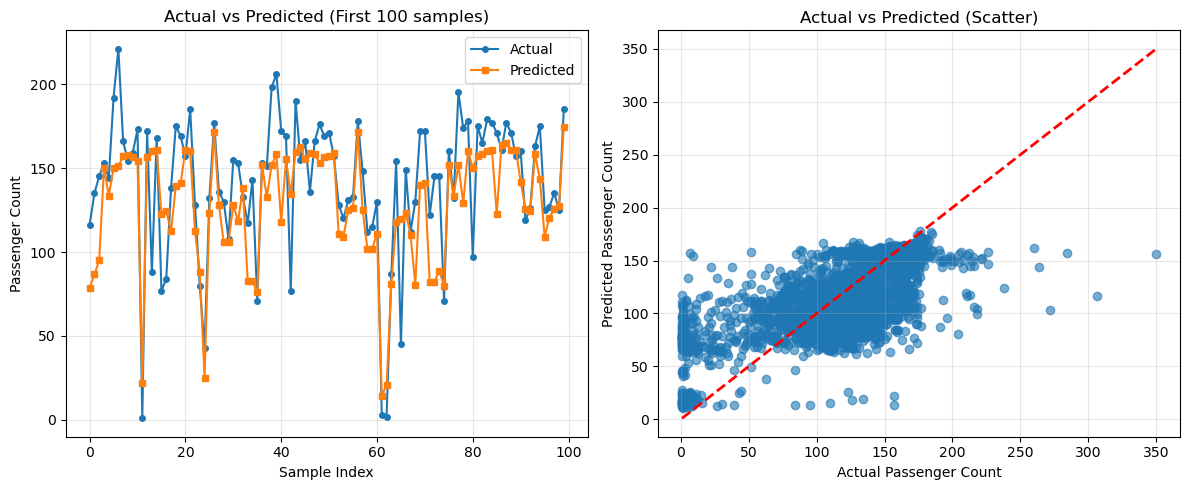

In [33]:
# Plot actual vs predicted
plt.figure(figsize=(12, 5))

# Line plot
plt.subplot(1, 2, 1)
plt.plot(y_test.values[:100], label='Actual', marker='o', markersize=4)
plt.plot(y_pred[:100], label='Predicted', marker='s', markersize=4)
plt.title('Actual vs Predicted (First 100 samples)')
plt.xlabel('Sample Index')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Passenger Count')
plt.ylabel('Predicted Passenger Count')
plt.title('Actual vs Predicted (Scatter)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Feature Importance:
                        feature  importance
11                   route_mean    0.295922
12                 route_median    0.256056
1               Airline_encoded    0.099049
13                    route_std    0.073584
7                     month_sin    0.045799
3                         Month    0.039246
8                     month_cos    0.031067
0   Destination Airport_encoded    0.029931
4                  Day_of_Month    0.029548
5                       day_sin    0.028481
6                       day_cos    0.021150
10                      dow_cos    0.019941
2                   Day_of_Week    0.017451
9                       dow_sin    0.012774


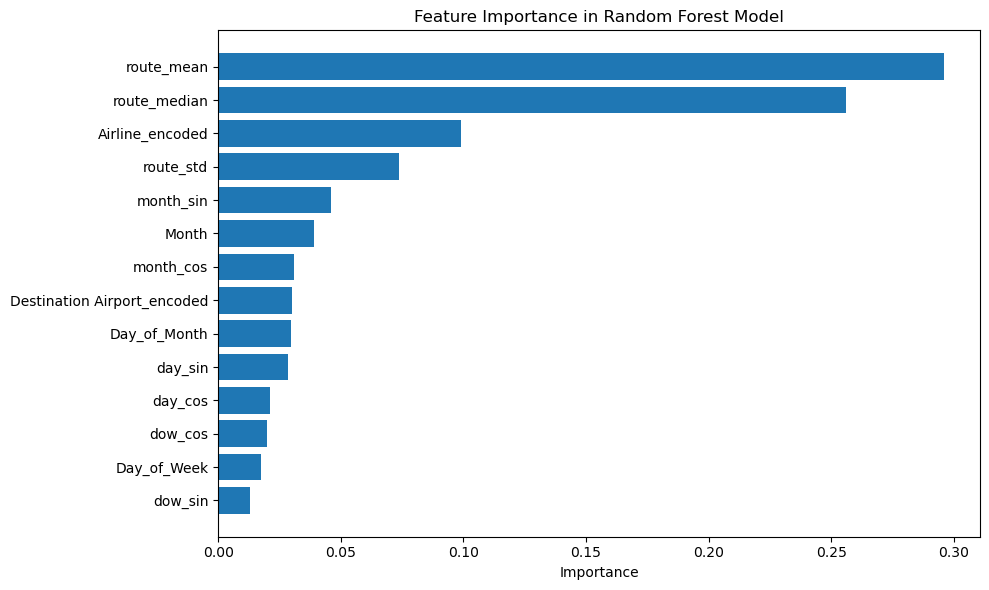

In [26]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()